In [1]:
# Proyecto IA - Reconocimiento de Imagenes
# Mike Leonel Molina García 201212535
# Hector Josue Orozco Salazar - 201314296

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
import glob as gb
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg
from tqdm import tqdm
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.optimizers import Adam

from keras.applications import DenseNet121
from keras.applications import ResNet50V2
from keras.applications import ResNet152V2
from keras.applications import InceptionV3
from keras.applications import Xception

2023-12-28 19:21:11.670211: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-28 19:21:12.790097: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-28 19:21:12.791121: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-28 19:21:12.987475: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-28 19:21:13.394706: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-28 19:21:13.399848: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
train_path = '/home/ldev/ia/proyecto/basedata/training'
test_path = '/home/ldev/ia/proyecto/basedata/testing'

In [3]:
# Aumento de datos para entrenamiento.
train_datagen = ImageDataGenerator(
    rescale=1.0/255,                # Cambiar la escala de los valores de píxeles a [0, 1]
    rotation_range=20,              # Rotación aleatoria dentro de 20 grados.
    width_shift_range=0.2,          # Desplazamiento horizontal aleatorio en un 20% del ancho de la imagen
    height_shift_range=0.2,         # Desplazamiento vertical aleatorio en un 20% de la altura de la imagen
    horizontal_flip=True,           # Voltear horizontalmente
    fill_mode='nearest'             # Modo de relleno para nuevos píxeles después de cambios/rotaciones
)

In [4]:
images_size = 200
batch_size = 32

In [5]:
train_generator = train_datagen.flow_from_directory(
    train_path,                     # Ruta a los datos de entrenamiento.
    target_size=(images_size, images_size),  # Cambiar el tamaño de las imágenes a este tamaño
    batch_size=batch_size,           # Número de imágenes en cada lote
    seed=32,                         # Opcional: establezca una semilla aleatoria para barajar
    shuffle=True,                    # Mezclar los datos durante el entrenamiento
    class_mode='categorical'        # Modo para etiquetas de clase (categórico para codificación one-hot)
)

Found 24998 images belonging to 2 classes.


/home/ldev/anaconda3/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


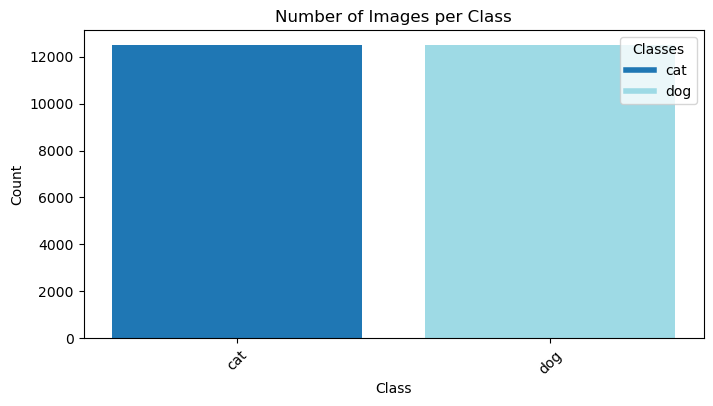

In [6]:
# Obtener las etiquetas de clase
class_labels = list(train_generator.class_indices.keys())

# Calcular el recuento de imágenes por clase.
class_counts = {label: 0 for label in class_labels}

for i in range(len(train_generator)):
    batch_data, batch_labels = train_generator[i]
    for j in range(len(batch_data)):
        class_idx = int(batch_labels[j].argmax())
        class_label = class_labels[class_idx]
        class_counts[class_label] += 1

# Definir colores únicos para cada clase.
class_colors = plt.cm.tab20(np.linspace(0, 1, len(class_labels)))

# Crea un gráfico de barras con diferentes colores para cada clase.
plt.figure(figsize=(8, 4))
bars = plt.bar(class_counts.keys(), class_counts.values(), color=class_colors)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Images per Class')
plt.xticks(rotation=45)

# Agregar una leyenda para los colores de clase
legend_labels = [plt.Line2D([0], [0], color=class_colors[i], lw=4, label=class_labels[i]) for i in range(len(class_labels))]
plt.legend(handles=legend_labels, title="Classes")

plt.show()

In [27]:
# aumento de datos para pruebas
test_datagen = ImageDataGenerator(rescale=1.0/255)  # Rescale pixel values to [0, 1]

In [28]:
# Crear un generador para probar datos
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(images_size, images_size),
    batch_size = batch_size,
    class_mode='categorical')

Found 6249 images belonging to 2 classes.


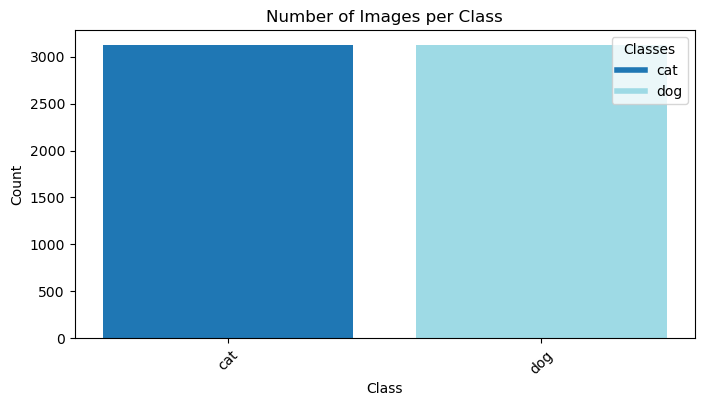

In [29]:
# Obtener las etiquetas de clase
class_labels = list(test_generator.class_indices.keys())

# Calcular el recuento de imágenes por clase.
class_counts = {label: 0 for label in class_labels}

for i in range(len(test_generator)):
    batch_data, batch_labels = test_generator[i]
    for j in range(len(batch_data)):
        class_idx = int(batch_labels[j].argmax())
        class_label = class_labels[class_idx]
        class_counts[class_label] += 1

# Definir colores únicos para cada clase.
class_colors = plt.cm.tab20(np.linspace(0, 1, len(class_labels)))

# Crea un gráfico de barras con diferentes colores para cada clase.
plt.figure(figsize=(8, 4))
bars = plt.bar(class_counts.keys(), class_counts.values(), color=class_colors)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Images per Class')
plt.xticks(rotation=45)

# Agregar una leyenda para los colores de clase
legend_labels = [plt.Line2D([0], [0], color=class_colors[i], lw=4, label=class_labels[i]) for i in range(len(class_labels))]
plt.legend(handles=legend_labels, title="Classes")

plt.show()

In [30]:
def Show_Images(target_gen):
    # Obtener un lote de imágenes y etiquetas.
    batch_images, batch_labels = next(target_gen)

    # Obtener etiquetas de clase
    class_labels = list(target_gen.class_indices.keys())

    # Mostrar imágenes con etiquetas
    plt.figure(figsize=(20, 20))
    for n , i in enumerate(list(np.random.randint(0,len(batch_images),16))):
        plt.subplot(4, 4, n + 1)
        plt.imshow(batch_images[i])
        plt.title(class_labels[np.argmax(batch_labels[i])])  # Mostrar la etiqueta de clase
        plt.axis('off')
    plt.show()

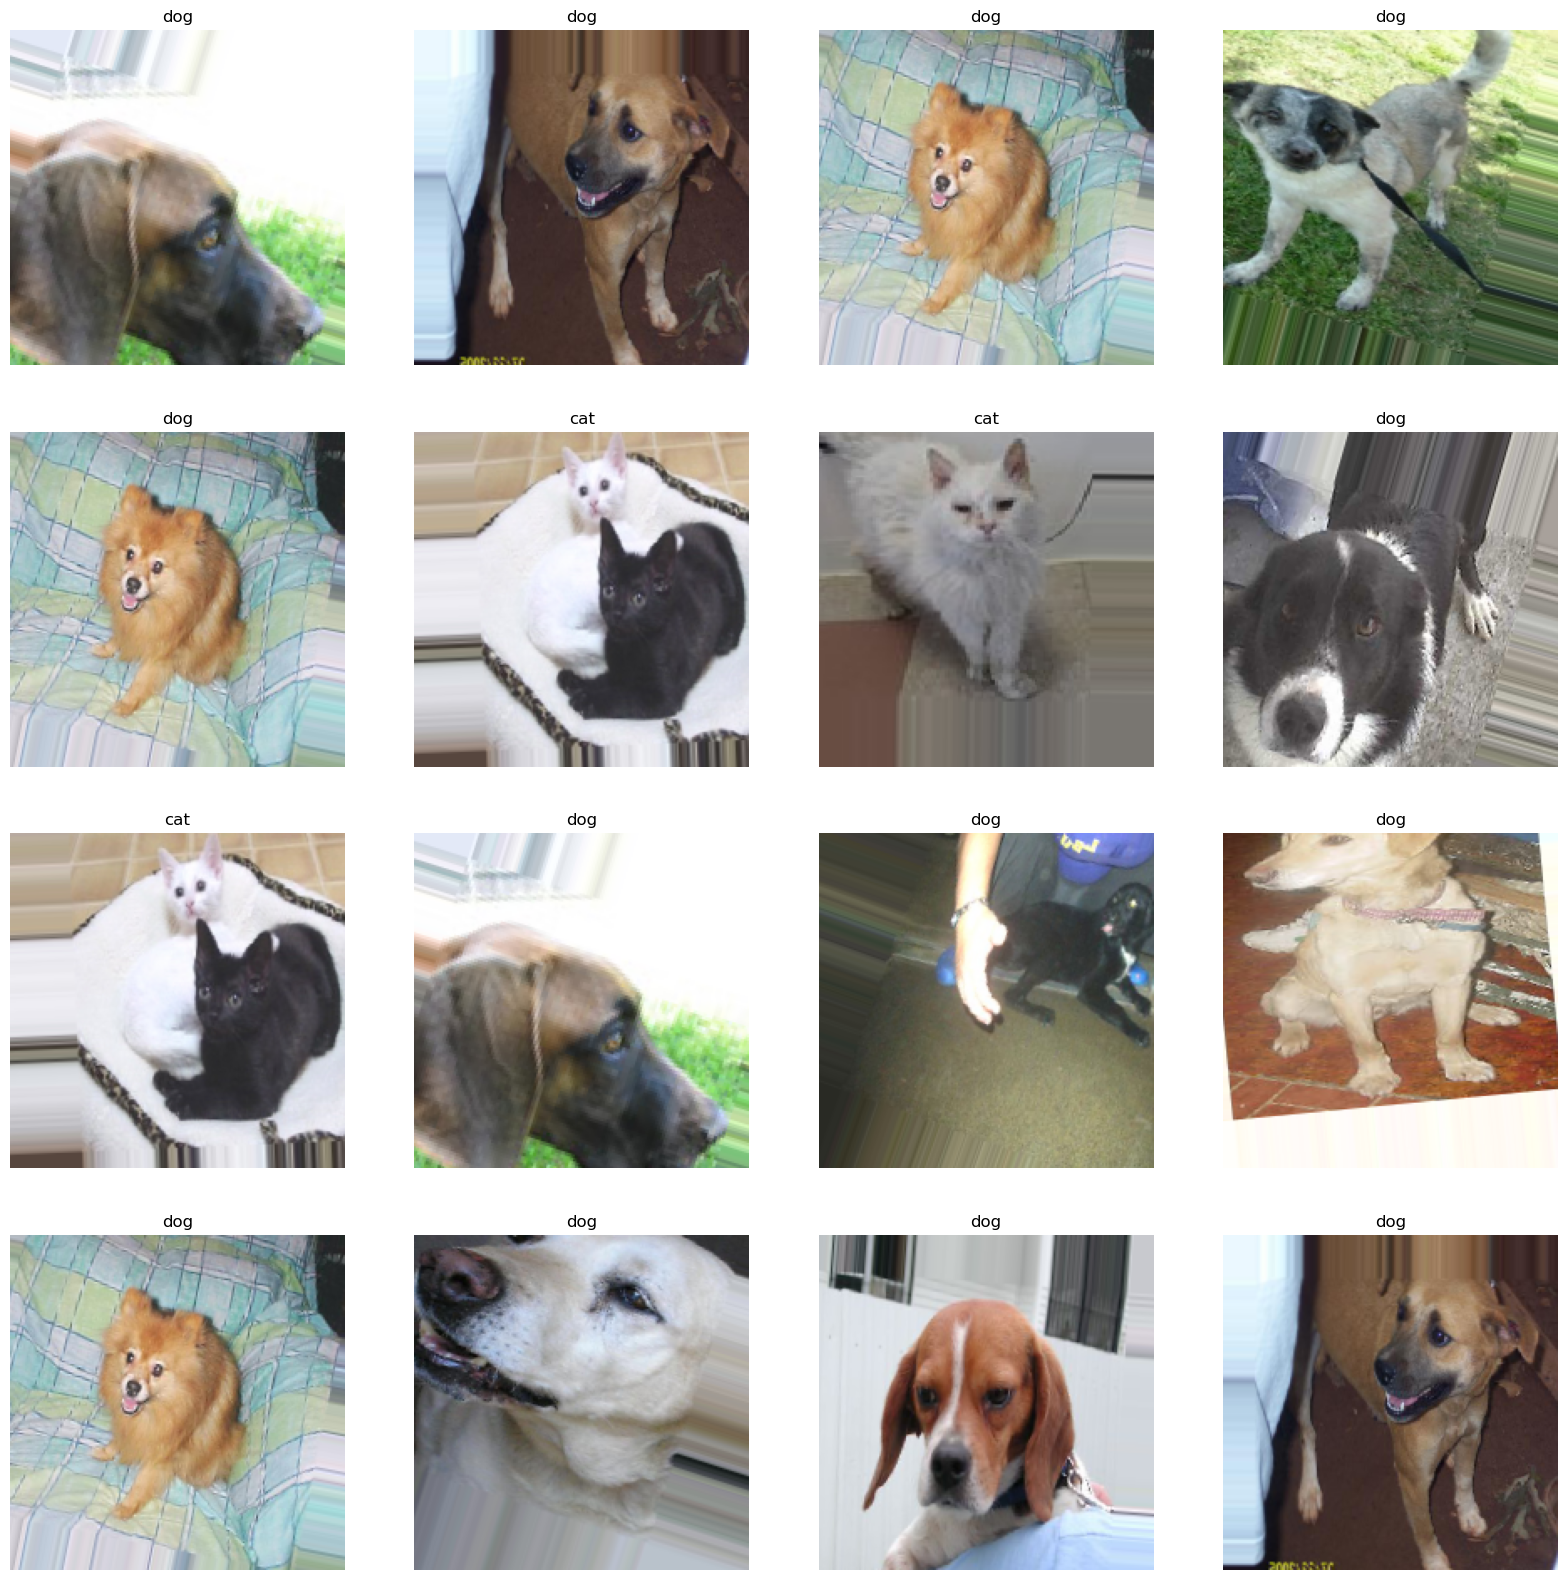

In [31]:
Show_Images(train_generator)

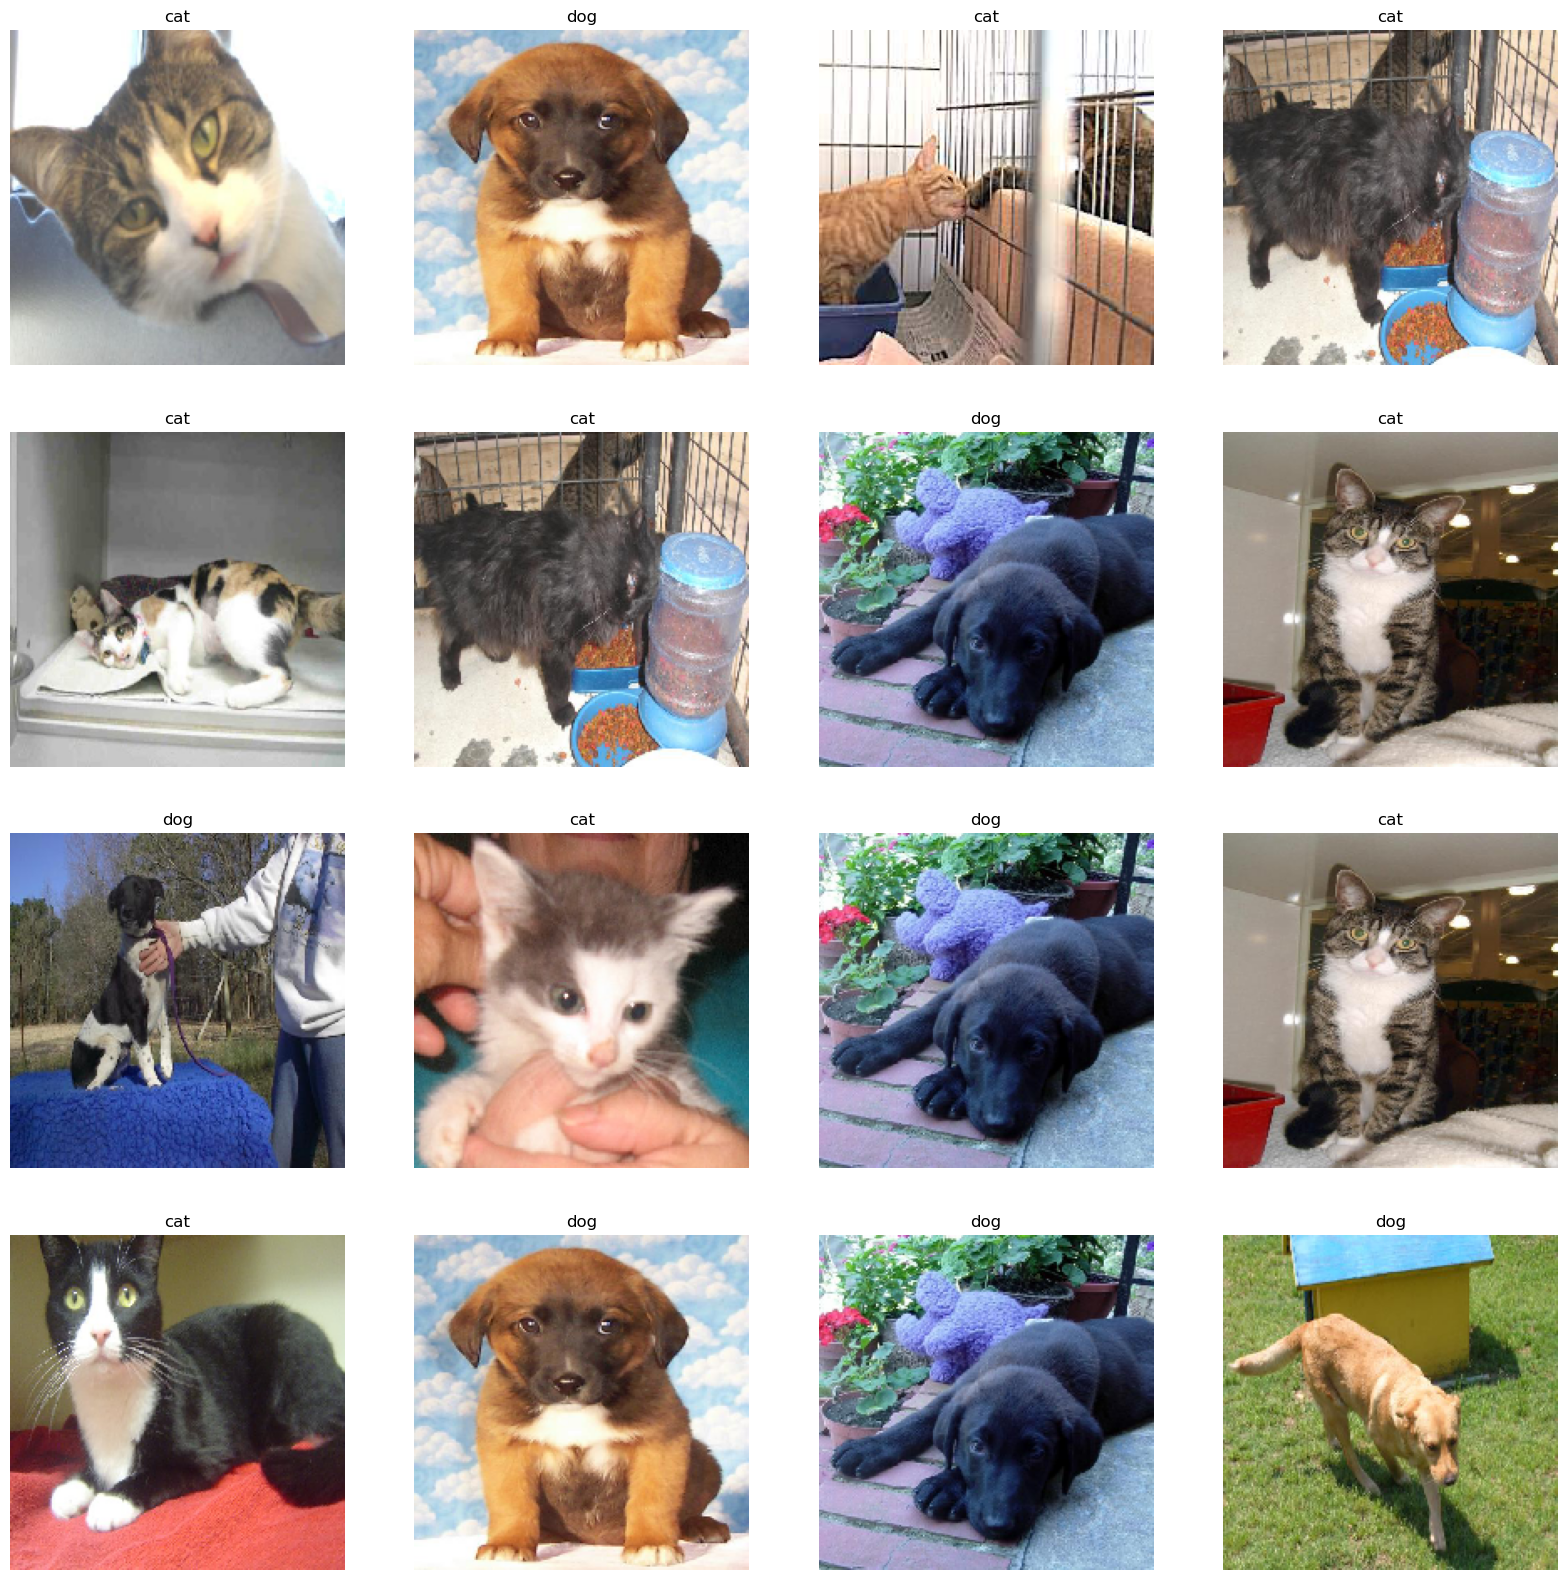

In [32]:
Show_Images(test_generator)

In [14]:
early_stopping = EarlyStopping(
    min_delta=0.001, # Cantidad mínima de cambio para contar como una mejora.
    patience=5, # cuanto esperar antes de detenerse
    restore_best_weights=True,
)

In [15]:
# Configurar la devolución de llamada de reducción de la tasa de aprendizaje
learning_rate_reduce = ReduceLROnPlateau(
    monitor='val_acc',   # Métrica para monitorear cambios (generalmente precisión de validación
    patience=5,          # Número de épocas sin mejora después de las cuales se reducirá la tasa de aprendizaje
    verbose=1,           # Modo detallado (0: silencio, 1: mensajes de actualización)
    factor=0.5,          # Factor por el cual se reducirá la tasa de aprendizaje (por ejemplo, 0,5 significa reducir a la mitad)
    min_lr=0.00001       # Límite inferior para la tasa de aprendizaje (no irá por debajo de este valor)
)



In [16]:
from tensorflow.keras import optimizers

# Cree un programa de tasa de aprendizaje usando Exponential Decay
learning_rate_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,  # Tasa de aprendizaje inicial para la formación.
    decay_steps=1000,            # Número de pasos antes de disminuir la tasa de aprendizaje
    decay_rate=0.5,              # Velocidad a la que disminuye la tasa de aprendizaje
)

# learning_rate = initial_learning_rate * decay_rate ^ (global_step / decay_steps)


In [17]:
from keras.callbacks import LearningRateScheduler

# Cree una devolución de llamada del Programador de tasa de aprendizaje usando un horario predefinidolr_callback = LearningRateScheduler(learning_rate_schedule)
callback=[ lr_callback , learning_rate_reduce ,early_stopping ]


In [18]:
# Colecciona todos los modelos TL
TL_Models =[
    ResNet50V2(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
    ResNet152V2(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
    InceptionV3(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
    Xception(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
    DenseNet121( input_shape=(images_size, images_size, 3) ,weights='imagenet', include_top=False),
]

# Defina todos los nombres de los modelos TL. Esto se utilizará más adelante durante la visualización.
TL_Models_NAMES = [
    'ResNet50V2',
    'ResNet152V2',
    'InceptionV3',
    'Xception',
    'DenseNet121',
]

# Congela los pesos de todos los modelos TL
for tl_model in TL_Models:
    tl_model.trainable = False

29084464/29084464 [==============================] - 29s 1us/step


In [19]:
#  Crear variables para recopilar imágenes y etiquetas.
subset_images = []
subset_labels = []

# Establezca la cantidad deseada de imágenes que desee en el subconjunto
desired_count = 1000

# Recorra el generador hasta que haya recopilado la cantidad deseada de imágenes.
for i in range(desired_count):
    # Generar un lote de datos (imágenes y etiquetas)
    batch = train_generator.next()
    images, labels = batch
    subset_images.extend(images)
    subset_labels.extend(labels)

    # Comprueba si has recopilado suficientes imágenes.
    if len(subset_images) >= desired_count:
        break

# Convierta las imágenes y etiquetas recopiladas en matrices numerosas
X_sub = np.array(subset_images)
y_sub = np.array(subset_labels)

In [20]:
# Inicialice una lista vacía para contener los historiales de cada arquitectura TL_models.
HISTORIES = []

# Loop over every backbone in the BACKBONES list.
for tl_model in tqdm(TL_Models, desc="Training Tl Models"):
    
    # Cree la arquitectura de modelo más simple utilizando la red troncal actual.
    model = keras.Sequential([
        tl_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(2, activation='softmax')
    ])
    
    # Compile el modelo con la función de pérdida, el optimizador y las métricas especificados.
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate = learning_rate_schedule),
        metrics='accuracy'
    )
    
    # Entrene el modelo en un subconjunto de datos de entrenamiento.
    history = model.fit(
        X_sub, y_sub,
        epochs=10,
        validation_split=0.2,
        batch_size=batch_size
    )
        
    # Almacene el historial del modelo entrenado.
    HISTORIES.append(history.history)

Training Tl Models:   0%|                                 | 0/5 [00:00<?, ?it/s]

Epoch 1/10


2023-12-19 18:50:55.515839: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 393120000 exceeds 10% of free system memory.


26/26 [==============================] - 36s 1s/step - loss: 0.4052 - accuracy: 0.8901 - val_loss: 0.2430 - val_accuracy: 0.9561
Epoch 2/10
26/26 [==============================] - 30s 1s/step - loss: 0.1788 - accuracy: 0.9573 - val_loss: 0.2666 - val_accuracy: 0.9463
Epoch 3/10
26/26 [==============================] - 30s 1s/step - loss: 0.1671 - accuracy: 0.9695 - val_loss: 0.2773 - val_accuracy: 0.9512
Epoch 4/10
26/26 [==============================] - 30s 1s/step - loss: 0.0966 - accuracy: 0.9768 - val_loss: 0.2381 - val_accuracy: 0.9561
Epoch 5/10
26/26 [==============================] - 32s 1s/step - loss: 0.0797 - accuracy: 0.9744 - val_loss: 0.2756 - val_accuracy: 0.9512
Epoch 6/10
26/26 [==============================] - 31s 1s/step - loss: 0.0732 - accuracy: 0.9792 - val_loss: 0.2921 - val_accuracy: 0.9512
Epoch 7/10
26/26 [==============================] - 30s 1s/step - loss: 0.0990 - accuracy: 0.9805 - val_loss: 0.3245 - val_accuracy: 0.9463
Epoch 8/10
26/26 [=============

Training Tl Models:  20%|████▊                   | 1/5 [05:11<20:46, 311.73s/it]2023-12-19 18:56:07.100491: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 393120000 exceeds 10% of free system memory.


Epoch 1/10
26/26 [==============================] - 101s 4s/step - loss: 0.3630 - accuracy: 0.9048 - val_loss: 0.1443 - val_accuracy: 0.9756
Epoch 2/10
26/26 [==============================] - 88s 3s/step - loss: 0.1548 - accuracy: 0.9707 - val_loss: 0.1446 - val_accuracy: 0.9756
Epoch 3/10
26/26 [==============================] - 86s 3s/step - loss: 0.1078 - accuracy: 0.9792 - val_loss: 0.1676 - val_accuracy: 0.9610
Epoch 4/10
26/26 [==============================] - 85s 3s/step - loss: 0.1655 - accuracy: 0.9683 - val_loss: 0.1375 - val_accuracy: 0.9756
Epoch 5/10
26/26 [==============================] - 88s 3s/step - loss: 0.0621 - accuracy: 0.9866 - val_loss: 0.2357 - val_accuracy: 0.9756
Epoch 6/10
26/26 [==============================] - 85s 3s/step - loss: 0.0845 - accuracy: 0.9817 - val_loss: 0.2317 - val_accuracy: 0.9707
Epoch 7/10
26/26 [==============================] - 85s 3s/step - loss: 0.1246 - accuracy: 0.9719 - val_loss: 0.1959 - val_accuracy: 0.9756
Epoch 8/10
26/26 [=

Training Tl Models:  40%|█████████▌              | 2/5 [19:49<32:14, 644.87s/it]

Epoch 1/10


2023-12-19 19:10:45.066922: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 393120000 exceeds 10% of free system memory.


26/26 [==============================] - 22s 696ms/step - loss: 0.7499 - accuracy: 0.8755 - val_loss: 0.3063 - val_accuracy: 0.9463
Epoch 2/10
26/26 [==============================] - 16s 618ms/step - loss: 0.3406 - accuracy: 0.9499 - val_loss: 0.2028 - val_accuracy: 0.9512
Epoch 3/10
26/26 [==============================] - 16s 627ms/step - loss: 0.2240 - accuracy: 0.9658 - val_loss: 0.1366 - val_accuracy: 0.9561
Epoch 4/10
26/26 [==============================] - 15s 593ms/step - loss: 0.1667 - accuracy: 0.9634 - val_loss: 0.2069 - val_accuracy: 0.9561
Epoch 5/10
26/26 [==============================] - 13s 508ms/step - loss: 0.1470 - accuracy: 0.9719 - val_loss: 0.4800 - val_accuracy: 0.9317
Epoch 6/10
26/26 [==============================] - 13s 511ms/step - loss: 0.1858 - accuracy: 0.9658 - val_loss: 0.3337 - val_accuracy: 0.9512
Epoch 7/10
26/26 [==============================] - 14s 546ms/step - loss: 0.1441 - accuracy: 0.9756 - val_loss: 0.2355 - val_accuracy: 0.9561
Epoch 8/10

Training Tl Models:  60%|██████████████▍         | 3/5 [22:21<13:59, 419.84s/it]2023-12-19 19:13:16.265412: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 393120000 exceeds 10% of free system memory.


Epoch 1/10
26/26 [==============================] - 41s 1s/step - loss: 0.1847 - accuracy: 0.9316 - val_loss: 0.0497 - val_accuracy: 0.9902
Epoch 2/10
26/26 [==============================] - 35s 1s/step - loss: 0.0754 - accuracy: 0.9768 - val_loss: 0.0644 - val_accuracy: 0.9756
Epoch 3/10
26/26 [==============================] - 34s 1s/step - loss: 0.0445 - accuracy: 0.9792 - val_loss: 0.0619 - val_accuracy: 0.9805
Epoch 4/10
26/26 [==============================] - 33s 1s/step - loss: 0.0423 - accuracy: 0.9841 - val_loss: 0.0681 - val_accuracy: 0.9854
Epoch 5/10
26/26 [==============================] - 32s 1s/step - loss: 0.0501 - accuracy: 0.9829 - val_loss: 0.0424 - val_accuracy: 0.9854
Epoch 6/10
26/26 [==============================] - 33s 1s/step - loss: 0.0597 - accuracy: 0.9756 - val_loss: 0.0429 - val_accuracy: 0.9854
Epoch 7/10
26/26 [==============================] - 33s 1s/step - loss: 0.0526 - accuracy: 0.9841 - val_loss: 0.0546 - val_accuracy: 0.9902
Epoch 8/10
26/26 [==

Training Tl Models:  80%|███████████████████▏    | 4/5 [28:07<06:30, 390.50s/it]

Epoch 1/10


2023-12-19 19:19:02.232335: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 393120000 exceeds 10% of free system memory.


26/26 [==============================] - 40s 1s/step - loss: 0.5153 - accuracy: 0.8413 - val_loss: 0.0871 - val_accuracy: 0.9610
Epoch 2/10
26/26 [==============================] - 32s 1s/step - loss: 0.2099 - accuracy: 0.9365 - val_loss: 0.0744 - val_accuracy: 0.9756
Epoch 3/10
26/26 [==============================] - 33s 1s/step - loss: 0.2712 - accuracy: 0.9231 - val_loss: 0.0597 - val_accuracy: 0.9659
Epoch 4/10
26/26 [==============================] - 31s 1s/step - loss: 0.2165 - accuracy: 0.9389 - val_loss: 0.0711 - val_accuracy: 0.9707
Epoch 5/10
26/26 [==============================] - 31s 1s/step - loss: 0.1534 - accuracy: 0.9512 - val_loss: 0.0759 - val_accuracy: 0.9707
Epoch 6/10
26/26 [==============================] - 32s 1s/step - loss: 0.1251 - accuracy: 0.9560 - val_loss: 0.0722 - val_accuracy: 0.9756
Epoch 7/10
26/26 [==============================] - 32s 1s/step - loss: 0.1318 - accuracy: 0.9573 - val_loss: 0.0559 - val_accuracy: 0.9707
Epoch 8/10
26/26 [=============

Training Tl Models: 100%|████████████████████████| 5/5 [33:37<00:00, 403.44s/it]


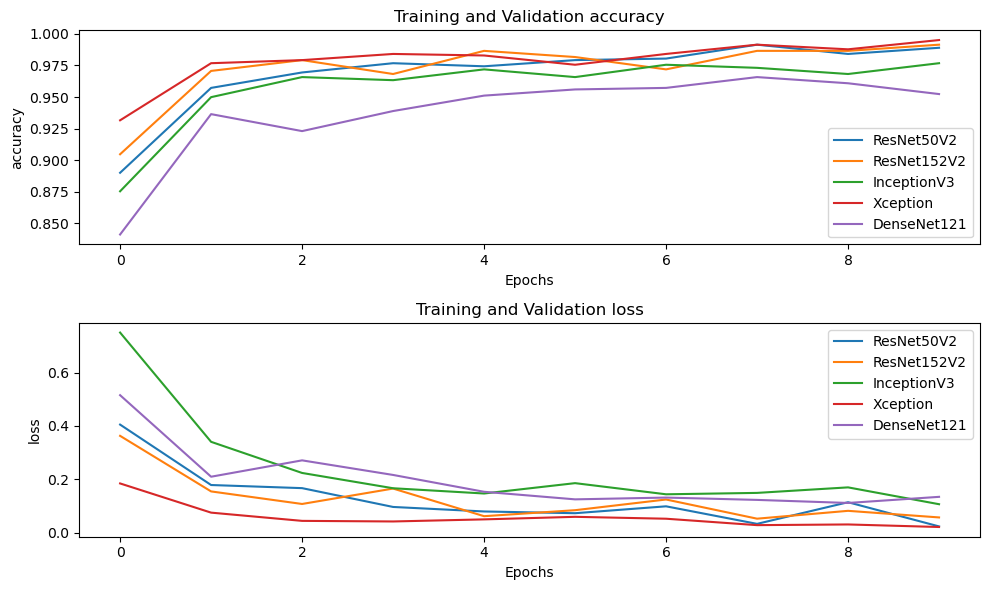

In [21]:
import matplotlib.pyplot as plt

# Definir las métricas a trazar (por ejemplo, 'precisión' y 'pérdida')
metrics_to_plot = ['accuracy', 'loss']

# Crear subtramas para cada métrica
fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(10, 6))

for i, metric in enumerate(metrics_to_plot):
    plt.subplot(2, 1, i+1)  # Crear subtramas para cada métrica
    for idx, history in enumerate(HISTORIES):
        plt.plot(history[metric], label=TL_Models_NAMES[idx])
    plt.title(f'Training and Validation {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()

plt.tight_layout()
plt.show()

In [22]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(images_size, images_size, 3))


In [23]:
# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

In [24]:
model = tf.keras.models.Sequential([
    base_model,
    
    layers.Flatten(),
    
    layers.Dense(256,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2,activation='softmax'),
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense_5 (Dense)             (None, 256)               25690368  
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 2)                 514       
                                                                 
Total params: 46552362 (177.58 MB)
Trainable params: 25690882 (98.00 MB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


In [25]:
optimizer = optimizers.Adam(learning_rate=learning_rate_schedule)

In [26]:
model.compile(optimizer=optimizer,
             loss="categorical_crossentropy",
              metrics=['accuracy']
             )

In [33]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[callback]
)

Epoch 1/20
781/781 [==============================] - 1215s 2s/step - loss: 2.7607 - accuracy: 0.9567 - val_loss: 0.0514 - val_accuracy: 0.9780 - lr: 0.0058
Epoch 2/20
781/781 [==============================] - 1212s 2s/step - loss: 0.1322 - accuracy: 0.9635 - val_loss: 0.0487 - val_accuracy: 0.9841 - lr: 0.0034
Epoch 3/20
781/781 [==============================] - 1207s 2s/step - loss: 0.1110 - accuracy: 0.9661 - val_loss: 0.0413 - val_accuracy: 0.9856 - lr: 0.0020
Epoch 4/20
781/781 [==============================] - 1215s 2s/step - loss: 0.0927 - accuracy: 0.9688 - val_loss: 0.0319 - val_accuracy: 0.9849 - lr: 0.0011
Epoch 5/20
781/781 [==============================] - 1135s 1s/step - loss: 0.0965 - accuracy: 0.9694 - val_loss: 0.0334 - val_accuracy: 0.9843 - lr: 6.6800e-04
Epoch 6/20
781/781 [==============================] - 1123s 1s/step - loss: 0.0721 - accuracy: 0.9740 - val_loss: 0.0298 - val_accuracy: 0.9877 - lr: 3.8875e-04
Epoch 7/20
781/781 [==============================

In [34]:
# Evaluar en el conjunto de datos de prueba
score = model.evaluate(test_generator, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.02874663472175598
Test accuracy: 0.9884781837463379


<Figure size 640x480 with 0 Axes>

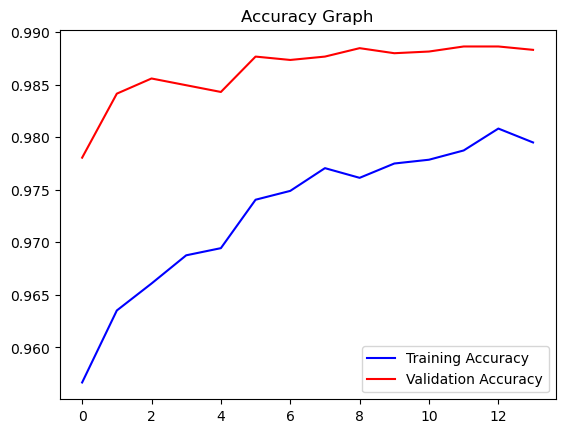

<Figure size 640x480 with 0 Axes>

In [35]:
# Exactitud
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

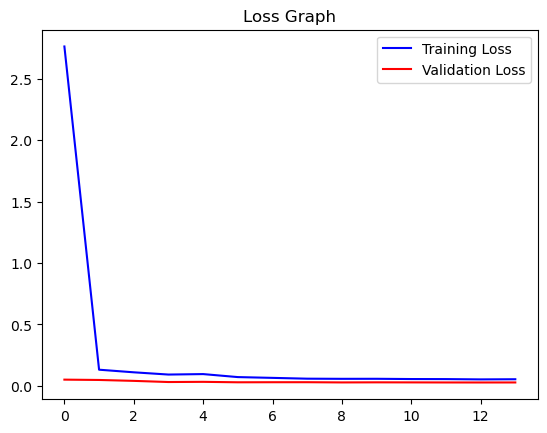

In [36]:
# Pérdida
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

196/196 [==============================] - 255s 1s/step


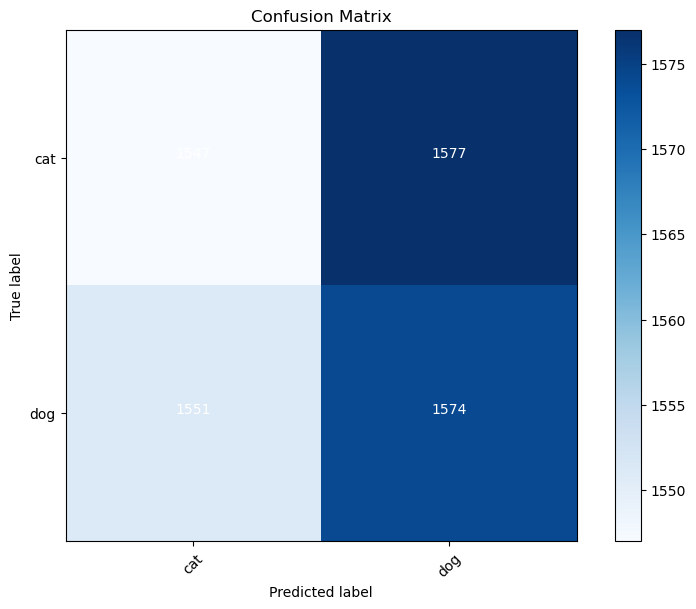

In [37]:
# Matriz de confusión
import itertools

# Hacer predicciones sobre los datos de prueba.
predictions = model.predict(test_generator)

# Convertir probabilidades en etiquetas de clase
predicted_labels = np.argmax(predictions, axis=1)

# Obtenga etiquetas verdaderas del test_generator
true_labels = test_generator.classes

# Calcular la matriz de confusión
cm = confusion_matrix(true_labels, predicted_labels)

# Defina nombres de clases (suponiendo que tenga class_names definidos)
class_names = test_generator.class_indices.keys()

# Matriz de confusión de la trama
def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

# Trazar una matriz de confusión no normalizada
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm, classes=class_names, title="Confusion Matrix")
plt.show()

1/1 [==============================] - 1s 1s/step


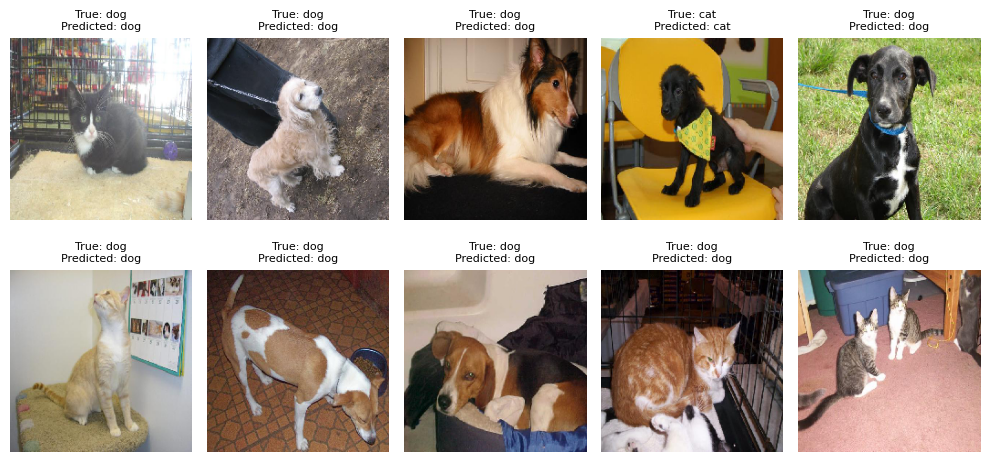

In [39]:
# Recopile etiquetas verdaderas y predicciones de modelos.
true_labels = []
predicted_labels = []
class_names = test_generator.class_indices.keys()    
class_names = list(class_names)
num_batches = len(test_generator)
for i in range(10):
    x_batch, y_batch = test_generator[i]
    predictions = model.predict(x_batch)
    true_labels.extend(np.argmax(y_batch, axis=1))  # Convierta etiquetas codificadas one-hot en índices de clase
    predicted_labels.extend(np.argmax(predictions, axis=1))


true_class_labels = [class_names[i] for i in true_labels]
predicted_class_labels = [class_names[i] for i in predicted_labels]

# Trazar etiquetas verdaderas y etiquetas previstas
plt.figure(figsize=(10, 5))
num_samples_to_display = min(10, len(x_batch))  # Muestra hasta 10 muestras o menos si están disponibles
for i in range(num_samples_to_display):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_batch[i])
    plt.title(f'True: {true_class_labels[i]}\nPredicted: {predicted_class_labels[i]}', fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [40]:
model.save("/home/ldev/ia/proyecto/model")

INFO:tensorflow:Assets written to: /home/ldev/ia/proyecto/model/assets


INFO:tensorflow:Assets written to: /home/ldev/ia/proyecto/model/assets


In [41]:
# Convertir el modelo
converter = tf.lite.TFLiteConverter.from_saved_model("/home/ldev/ia/proyecto/model") # path to the SavedModel directory
tflite_model = converter.convert()

# Guarde el modelo.
with open('/home/ldev/ia/proyecto/mlite/model.tflite', 'wb') as f:
  f.write(tflite_model)

2023-12-20 07:15:24.342438: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-12-20 07:15:24.342871: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-12-20 07:15:24.372428: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /home/ldev/ia/proyecto/model
2023-12-20 07:15:24.419578: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-12-20 07:15:24.419625: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /home/ldev/ia/proyecto/model
2023-12-20 07:15:24.516549: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2023-12-20 07:15:24.543189: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-12-20 07:15:29.144630: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: 